In [38]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt
from numba import cuda
from keras_tuner import HyperModel, Hyperband, Objective
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, r2_score, roc_auc_score
from tensorflow.keras.metrics import Recall, Precision, MeanSquaredError
from keras.regularizers import l2
import seaborn as sns

In [2]:
tf.config.list_physical_devices('GPU') # verifica se detectou a GPU

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
cuda.select_device(0) # seleciona a GPU
cuda.close() # limpa a memória da GPU

# Preparação dos dados

In [4]:
df = pd.read_csv('C:\\Users\\Henrique\\Desktop\\trab 3 IA\\HIGGS_100k.csv')

Agora que temos nosso conjunto de dados, vamos nomear as colunas:

In [5]:
columns = ['label', 'lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 
           'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 
           'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 
           'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

In [6]:
df.columns = columns

Com as colunas nomeadas, vamos verificar a existencia de dados faltantes:

In [7]:
print(df.isna().sum())

label                       0
lepton pT                   0
lepton eta                  0
lepton phi                  0
missing energy magnitude    0
missing energy phi          0
jet 1 pt                    0
jet 1 eta                   0
jet 1 phi                   0
jet 1 b-tag                 0
jet 2 pt                    0
jet 2 eta                   0
jet 2 phi                   0
jet 2 b-tag                 0
jet 3 pt                    0
jet 3 eta                   0
jet 3 phi                   0
jet 3 b-tag                 0
jet 4 pt                    0
jet 4 eta                   0
jet 4 phi                   0
jet 4 b-tag                 0
m_jj                        0
m_jjj                       0
m_lv                        0
m_jlv                       0
m_bb                        0
m_wbb                       0
m_wwbb                      0
dtype: int64


Como podemos ver, não há dados faltantes. Agora iremos selecionar nossas features e target:

In [8]:
features = df.iloc[:, 1:22]
target = df['label']

separando em conjunto de teste e treino:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=666)

# Escolhendo os melhores hiperparâmetros

Agora irei otimizar a melhor escolha de hiperparâmetros para montar minha rede neural utilizando o keras tuner. O fator determinador de qual conjunto de hiperparâmetros a ser escolhido será a métrica AUC. Para evitar overfitting, irei colocar opções de dropout na escolha de hiperparâmetros, além de utilizar a função EarlyStopping, ReduceLROnPlateau e fazer uso da regularização L2.

In [10]:
def construir_modelo(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('qnt_neurônios_entrada', min_value=1, max_value=21, step=2),  # alterna a quantidade de neoronios na camada inicial entre 32 até 512 com passo 32
                    activation=hp.Choice('ativacao_entrada', values=['relu', 'tanh', 'elu', 'selu']),  # alterna a função de ativação na camada inicial entre 'relu', 'tanh', 'elu' e 'selu'
                    kernel_regularizer=l2(hp.Float('L2_entrada', min_value=1e-5, max_value=1e-2, sampling='LOG')), # alterna o coeficiente de regularização entre 1e-5 até 1e-2
                    input_dim=21)) # quantidade de dimenções = quantidade de features
    
    for i in range(hp.Int('qnt_camadas_ocultas', 1, 5)):  # alterna a quantidade de camadas ocultas entre 1 até 5 com passo 1
        model.add(Dense(units=hp.Int(f'qnt_neurônios_camada_oculta_{i}', min_value=1, max_value=21, step=2), # alterna a quantidade de neoronios nas camadas ocultas entre 32 até 512 com passo 32
                        activation=hp.Choice(f'ativacao_camada_oculta_{i}', values=['relu', 'tanh', 'elu', 'selu']), # alterna a função de ativação nas camadas ocultas entre 'relu', 'tanh', 'elu' e 'selu'
                        kernel_regularizer=l2(hp.Float(f'L2_camada_oculta_{i}', min_value=1e-5, max_value=1e-2, sampling='LOG')))) # alterna o coeficiente de regularização entre 1e-5 até 1e-2
        
        if hp.Boolean(f'normalização_camada_oculta_{i}', default=False): # alterna entre colocar ou não uma camada de normalização. Por padrão foi configurado não colocar.
            model.add(BatchNormalization())
        
        if hp.Boolean(f'dropout_camada_oculta_{i}', default=True):  # alterna entre colocar ou não um dropout. Por padrão foi configurado colocar.
            model.add(Dropout(rate=hp.Float(f'taxa_dropout_camada_oculta_{i}', min_value=0.1, max_value=0.5, step=0.1))) # alterna a taxa de dropout nas camadas ocultas entre 0.2 e 0.4 no passo 0.
    
    model.add(Dense(1, activation='sigmoid'))  # camada de saida com função de ativação sigmoidal.
    
    otimizador = hp.Choice('otimizador', values=['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta']) # alterna entre os otimizadores 'adam', 'rmsprop', 'sgd', 'adagrad' e 'adadelta'
    taxa_aprendizagem = hp.Float('taxa_aprendizagem', min_value=1e-5, max_value=1e-2, sampling='LOG') # alterna a taxa de aprendizagem entre 1e-2 e 1e-5
    
    if otimizador == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=taxa_aprendizagem)
    elif otimizador == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=taxa_aprendizagem)
    elif otimizador == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=taxa_aprendizagem)
    elif otimizador == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=taxa_aprendizagem)
    elif otimizador == 'adadelta':
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=taxa_aprendizagem)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc'),'accuracy', Precision(), Recall(), MeanSquaredError()])
    return model

In [11]:
tuner = Hyperband(
    construir_modelo,
    objective=Objective('val_auc', direction='max'), # Métrica a ser otimizada
    max_epochs=50, # Número máximo de épocas por modelo
    directory='my_dir', # Diretório para armazenar os resultados
    project_name='hyperparametros', # Nome do projeto
    seed = 666
)

Reloading Tuner from my_dir\hyperparametros\tuner0.json


In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # interrompe quando a métrica val_loss para de melhorar após 10 épocas
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6) # veririfca a metrica val_loss, caso não melhore após 5 épocas, reduz a taxa de aprendizagem por um fator 0.2 até um mínimo de 1e-6

In [13]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping]) # procura o melhor conjunto de hiperparâmetros

In [14]:
params = tuner.get_best_hyperparameters(num_trials=1)[0]

In [15]:
print("Melhores hiperparâmetros:")
print("----------------------------")
print(f"Função de ativação da camada inicial: {params['ativacao_entrada']}")
print(f"Número de neurônios na camada inicial: {params['qnt_neurônios_entrada']}")
print(f"coeficiente de regularização L2 na camada inicial : {params['L2_entrada']}")
for i in range(params['qnt_camadas_ocultas']):
    print(f"\nCamada Oculta {i+1}:")
    print(f"Função de ativação: {params[f'ativacao_camada_oculta_{i}']}")
    print(f"Número de neurônios: {params[f'qnt_neurônios_camada_oculta_{i}']}")
    print(f"coeficiente de regularização L2: {params[f'L2_camada_oculta_{i}']}") #
    if params[f'dropout_camada_oculta_{i}']:
        print(f"Taxa de dropout: {params[f'taxa_dropout_camada_oculta_{i}']}")
    else:
        print("Sem dropout nesta camada.")
    if params[f'normalização_camada_oculta_{i}']:
        print("Com camada de normalização.")
    else:
        print("Sem camada de normalização nesta camada.")
print("\nOtimizador escolhido:", params['otimizador'])
print("Taxa de aprendizado:", params['taxa_aprendizagem'])

Melhores hiperparâmetros:
----------------------------
Função de ativação da camada inicial: selu
Número de neurônios na camada inicial: 13
coeficiente de regularização L2 na camada inicial : 5.605482858797139e-05

Camada Oculta 1:
Função de ativação: tanh
Número de neurônios: 17
coeficiente de regularização L2: 1.4266740007804309e-05
Sem dropout nesta camada.
Com camada de normalização.

Camada Oculta 2:
Função de ativação: elu
Número de neurônios: 17
coeficiente de regularização L2: 7.967256753528906e-05
Sem dropout nesta camada.
Com camada de normalização.

Otimizador escolhido: rmsprop
Taxa de aprendizado: 0.003332283580166981


# Treinando a rede neural

agora que temos o melhor conjunto de hiperparâmetros, basta usar essa configuração de rede neural e treinar ela:

In [16]:
model = tuner.hypermodel.build(params) # cria o modelo com o melhor conjunto de hiperparâmetros
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping,reduce_lr]) # ajusta o modelo aos dados

Epoch 1/50
2500/2500 [==============================] - 15s 6ms/step - loss: 0.6778 - auc: 0.6031 - accuracy: 0.5741 - precision: 0.5858 - recall: 0.6595 - mean_squared_error: 0.2412 - val_loss: 0.6725 - val_auc: 0.6208 - val_accuracy: 0.5861 - val_precision: 0.5864 - val_recall: 0.7438 - val_mean_squared_error: 0.2386 - lr: 0.0033
Epoch 2/50
2500/2500 [==============================] - 14s 6ms/step - loss: 0.6612 - auc: 0.6448 - accuracy: 0.6058 - precision: 0.6129 - recall: 0.6876 - mean_squared_error: 0.2332 - val_loss: 0.6657 - val_auc: 0.6446 - val_accuracy: 0.6017 - val_precision: 0.6329 - val_recall: 0.5922 - val_mean_squared_error: 0.2351 - lr: 0.0033
Epoch 3/50
2500/2500 [==============================] - 14s 6ms/step - loss: 0.6545 - auc: 0.6588 - accuracy: 0.6158 - precision: 0.6228 - recall: 0.6900 - mean_squared_error: 0.2299 - val_loss: 0.6579 - val_auc: 0.6543 - val_accuracy: 0.6075 - val_precision: 0.6003 - val_recall: 0.7768 - val_mean_squared_error: 0.2316 - lr: 0.003

In [17]:
y_pred = (model.predict(X_test) > 0.5).astype("int32") # y_pred = 1 se a previsão for maior que 0.5 e 0 caso contrário

626/626 [==============================] - 1s 1ms/step


In [18]:
coluna_mwwbb = df.loc[X_test.index, 'm_wwbb'] # seleciona os valores de m_wwbb no conjunto de dados originais que correspondem aos index dos dados selecionados para X_test.
X_test['label'] = y_test # adiciona ao dataset X_test uma coluna 'label' com os valores originais de label
X_test['previsao'] = y_pred # adiciona ao dataset X_test uma coluna 'previsao' com os valores previstos pelo modelo
X_test['m_wwbb'] = coluna_mwwbb  # adiciona ao dataset X_test uma coluna 'm_wwbb' com os valores originais de m_wwbb

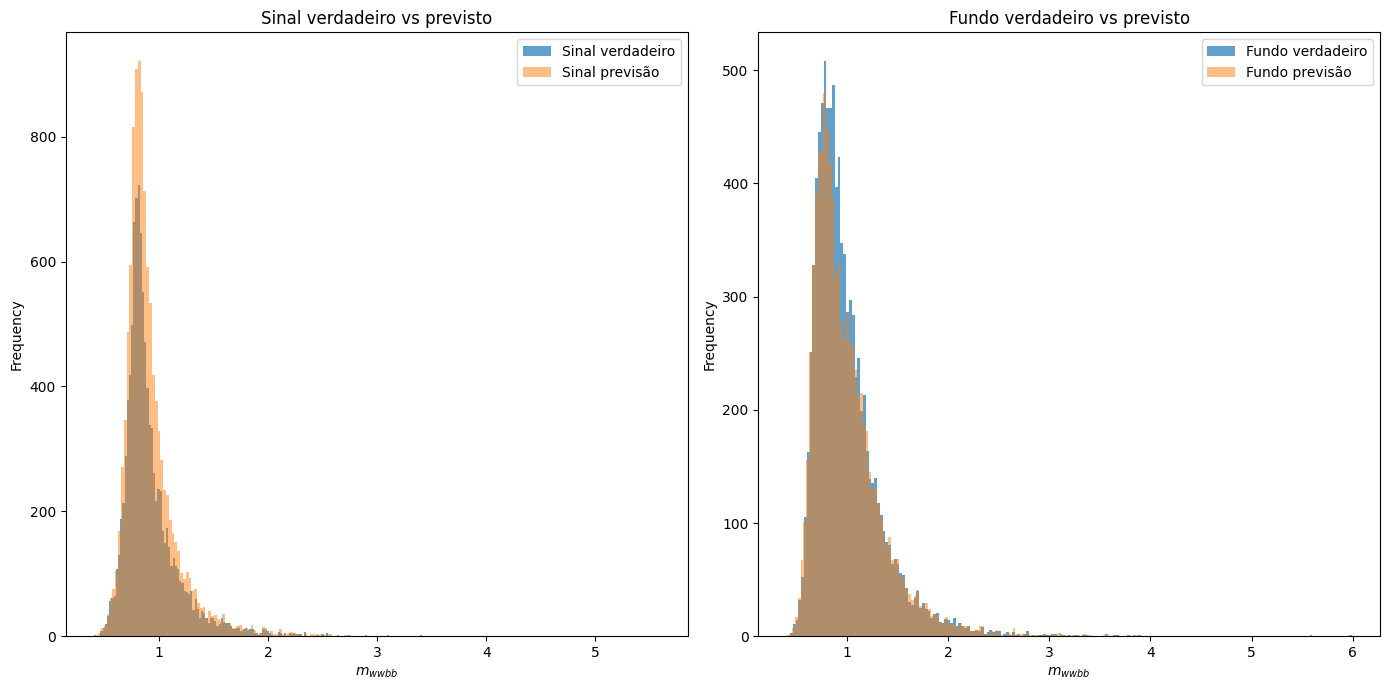

In [42]:
plt.figure(figsize=(14, 7))


plt.subplot(1, 2, 1)
plt.hist(X_test[X_test['label'] == 1]['m_wwbb'], bins=200, alpha=0.7, label='Sinal verdadeiro')
plt.hist(X_test[X_test['previsao'] == 1]['m_wwbb'], bins=200, alpha=0.5, label='Sinal previsão')
plt.xlabel('$m_{wwbb}$')
plt.ylabel('Frequency')
plt.title('Sinal verdadeiro vs previsto')
plt.legend()


plt.subplot(1, 2, 2)
plt.hist(X_test[X_test['label'] == 0]['m_wwbb'], bins=200, alpha=0.7, label='Fundo verdadeiro')
plt.hist(X_test[X_test['previsao'] == 0]['m_wwbb'], bins=200, alpha=0.5, label='Fundo previsão')
plt.xlabel('$m_{wwbb}$')
plt.ylabel('Frequency')
plt.title('Fundo verdadeiro vs previsto')
plt.legend()

plt.tight_layout()
plt.show()

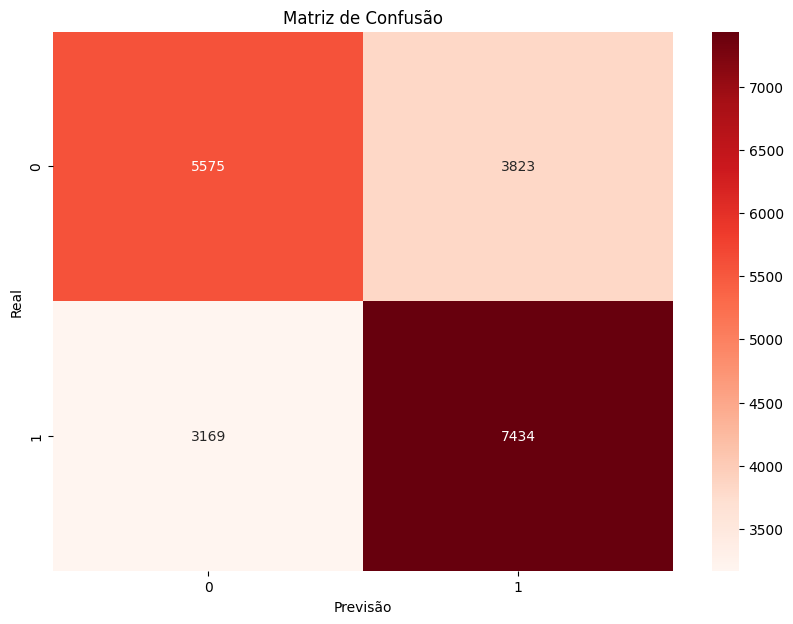

In [24]:
conf_matrix = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=True)
plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

# Métricas

In [25]:
print(np.isnan(y_pred).sum())

0


In [39]:
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

In [40]:
print (f' Acurácia: {accuracy}')
print (f' MSE: {mse}')
print (f' Recall: {recall}')
print (f' Precision: {precision}')
print (f' F1: {f1}')
print (f' AUC: {auc}')

 Acurácia: 0.6504174791260438
 MSE: 0.3495825208739563
 Recall: 0.7011223238706027
 Precision: 0.6603890912321222
 F1: 0.6801463860933211
 AUC: 0.6471668227141905


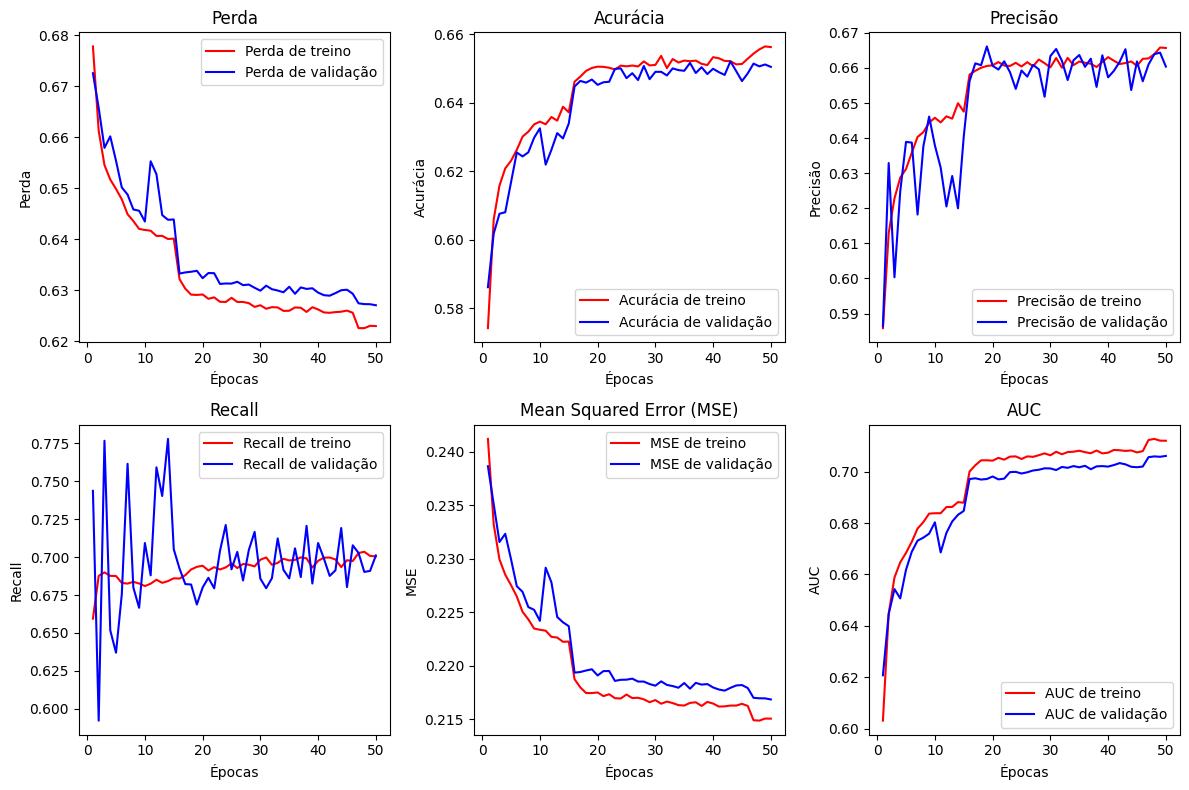

In [43]:
# Plotando as métricas
epochs = range(1, 51)
plt.figure(figsize=(12, 8))

# Plotando loss
plt.subplot(2, 3, 1)
plt.plot(epochs, history.history['loss'], 'r', label='Perda de treino')
plt.plot(epochs, history.history['val_loss'], 'b', label='Perda de validação')
plt.title('Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Plotando acurácia
plt.subplot(2, 3, 2)
plt.plot(epochs, history.history['accuracy'], 'r', label='Acurácia de treino')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Acurácia de validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Plotando precisão
plt.subplot(2, 3, 3)
plt.plot(epochs, history.history['precision'], 'r', label='Precisão de treino')
plt.plot(epochs, history.history['val_precision'], 'b', label='Precisão de validação')
plt.title('Precisão')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()

# Plotando recall
plt.subplot(2, 3, 4)
plt.plot(epochs, history.history['recall'], 'r', label='Recall de treino')
plt.plot(epochs, history.history['val_recall'], 'b', label='Recall de validação')
plt.title('Recall')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Plotando F1-score
plt.subplot(2, 3, 5)
plt.plot(epochs, history.history['mean_squared_error'], 'r', label='MSE de treino')
plt.plot(epochs, history.history['val_mean_squared_error'], 'b', label='MSE de validação')
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(epochs, history.history['auc'], 'r', label='AUC de treino')
plt.plot(epochs, history.history['val_auc'], 'b', label='AUC de validação')
plt.title('AUC')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

## Conclusão

Na minha abordagem, utilizei o Keras tuner para encontrar o melhor conjunto de hiperparâmetros, isto é, o melhor modelo, para minha rede neural com o objetivo de maximizar a métrica AUC. O modelo encontrado foi:

In [34]:
print("Melhores hiperparâmetros:")
print("----------------------------")
print(f"Função de ativação da camada inicial: {params['ativacao_entrada']}")
print(f"Número de neurônios na camada inicial: {params['qnt_neurônios_entrada']}")
print(f"coeficiente de regularização L2 na camada inicial : {params['L2_entrada']}")
for i in range(params['qnt_camadas_ocultas']):
    print(f"\nCamada Oculta {i+1}:")
    print(f"Função de ativação: {params[f'ativacao_camada_oculta_{i}']}")
    print(f"Número de neurônios: {params[f'qnt_neurônios_camada_oculta_{i}']}")
    print(f"coeficiente de regularização L2: {params[f'L2_camada_oculta_{i}']}") #
    if params[f'dropout_camada_oculta_{i}']:
        print(f"Taxa de dropout: {params[f'taxa_dropout_camada_oculta_{i}']}")
    else:
        print("Sem dropout nesta camada.")
    if params[f'normalização_camada_oculta_{i}']:
        print("Com camada de normalização.")
    else:
        print("Sem camada de normalização nesta camada.")
print("\nOtimizador escolhido:", params['otimizador'])
print("Taxa de aprendizado:", params['taxa_aprendizagem'])

Melhores hiperparâmetros:
----------------------------
Função de ativação da camada inicial: selu
Número de neurônios na camada inicial: 13
coeficiente de regularização L2 na camada inicial : 5.605482858797139e-05

Camada Oculta 1:
Função de ativação: tanh
Número de neurônios: 17
coeficiente de regularização L2: 1.4266740007804309e-05
Sem dropout nesta camada.
Com camada de normalização.

Camada Oculta 2:
Função de ativação: elu
Número de neurônios: 17
coeficiente de regularização L2: 7.967256753528906e-05
Sem dropout nesta camada.
Com camada de normalização.

Otimizador escolhido: rmsprop
Taxa de aprendizado: 0.003332283580166981


Neste modelo, foi utilizada a técnica de regularização L2 para evitar overfitting. A pesquisa do melhor modelo deciciu que não era necessário dropout nas camadas ocultas. Além disso, para evitar overfitting, foi utilizado as funções EarlyStopping, que interrompia o treinamento caso a perda de validação não melhorasse após 10 épocas, e ReduceLROnPlateau, que reduzia a taxa de aprendizagem por uma faotr 0.2 caso a perda de validação não melhorasse após 5 épocas.

Mesmo com essas abordagens, o modelo não conseguiu evitar overfitting.

O modelo, até certo ponto, generalizou bem para o conjunto de teste, mas como pode-se ver, o modelo se adaptou melhor para o conjunto de treino, obtendo melhores métricas. Houve overfitting, mas mesmo mudando bruscamente o modelo da rede neural, não consegui evitar overfitting e nem uma previsão razoável para o conjunto teste.

Como o exercício exigia a utilização das 21 low-level features, talvez este seja o problema encontrado pela rede neural. Provavelmente, se utilizarmos novas variáveis e/ou algumas das high-level features podemos melhorar o desempenho da predição.